# Config



In [1]:
!pip install opencv-contrib-python==3.4.13.47 #--force-reinstall

     |████████████████████████████████| 53.7 MB 3.1 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join
import glob

In [4]:
ROOT_COLAB = '/content/drive/MyDrive/Colab Notebooks/cell_detection_AI/darknet'
YOLO_CONFIG = ROOT_COLAB + '/doc_data/'
COCO_LABELS_FILE = YOLO_CONFIG + 'document.names' # a file with the label the AI has to evaluate
YOLO_CONFIG_FILE = YOLO_CONFIG + 'yolov4_custom.cfg' # a config file for the darknet network
YOLO_WEIGHTS_FILE = YOLO_CONFIG + 'yolov4_custom_best.weights' # the weights file obtained after the training of the AI
LABELS_FROM_FILE = False
TEST_DIRECTORY = 'test/' # the directory for the videos used for A.I. testing after training

VIDEO_DIRECTORY = 'video_test' # the directory with the frames of the video (in a jpg or png format) you need to evaluate

IMAGE_FILE = 'FDG82336_2021122_TMS_940nm_D7_controlSTIMO-2_stim1Hz.czi - C=10000' # the name of the frame you want to evaluate
EXTENSION = '.jpg' # the extension of the frame format (either .jpg or .png)

IMAGE = cv2.imread(YOLO_CONFIG + TEST_DIRECTORY + IMAGE_FILE + EXTENSION)
CONFIDENCE_MIN = 0.5

# IMAGE

# Resize de l'image

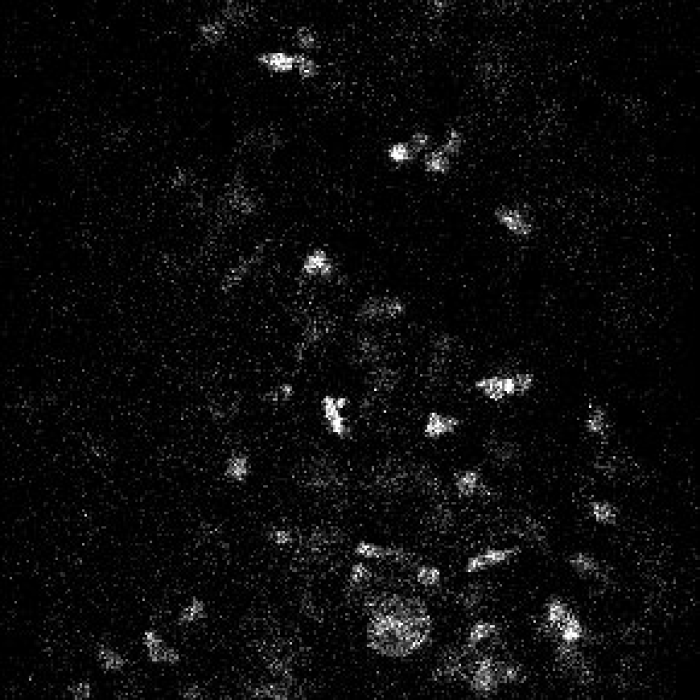

In [7]:
# Little function to resize in keeping the format ratio
# Cf. https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)
 
cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700)) 

# Prepare YOLO

In [10]:
(H, W) = IMAGE.shape[:2]
(H, W)

(290, 290)

In [11]:
with open(COCO_LABELS_FILE, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')
len(labels)

1

In [12]:
np.random.seed(45)
BOX_COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [13]:
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

In [14]:
yololayers = [yolo.getLayerNames()[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]
yololayers

['yolo_139', 'yolo_150', 'yolo_161']

In [16]:
blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416), swapRB=True, crop=False)

In [17]:
yolo.setInput(blobimage)

# Apply YOLO

In [18]:
layerOutputs = yolo.forward(yololayers)
layerOutputs[0].shape

(8112, 6)

In [19]:
boxes_detected = []
confidences_scores = []
labels_detected = []

In [20]:
# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
    # extract the class ID and confidence (i.e., probability) of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
 
    # Take only predictions with confidence more than CONFIDENCE_MIN thresold
    if confidence > CONFIDENCE_MIN:
      # Bounding box
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")
 
      # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
 
      # update our result list (detection)
      boxes_detected.append([x, y, int(width), int(height)])
      confidences_scores.append(float(confidence))
      labels_detected.append(classID)

In [21]:
nb_results = len(boxes_detected)
nb_results

94

In [22]:
# labels_detected

In [23]:
label_names = [labels[i] for i in labels_detected]
# label_names

In [24]:
# confidences_scores

In [25]:
# boxes_detected

# Apply NMS Algorithm


In [26]:
final_boxes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, 0.5, 0.5)

In [27]:
# final_boxes

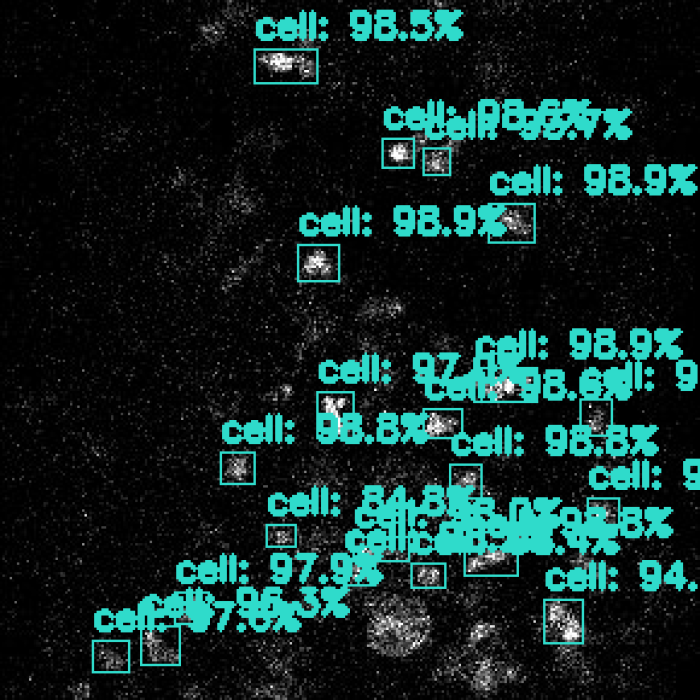

[[202, 84, 19, 16],
 [196, 152, 26, 14],
 [123, 101, 17, 15],
 [192, 226, 22, 12],
 [91, 187, 14, 13],
 [186, 192, 13, 14],
 [158, 57, 13, 12],
 [175, 169, 16, 12],
 [240, 165, 13, 15],
 [105, 20, 26, 14],
 [170, 233, 14, 10],
 [142, 232, 13, 10],
 [146, 222, 23, 10],
 [72, 245, 14, 13],
 [38, 265, 15, 13],
 [243, 206, 13, 11],
 [131, 162, 15, 19],
 [58, 259, 16, 16],
 [225, 248, 16, 18],
 [175, 61, 11, 11],
 [110, 217, 12, 9]]

In [29]:
image = IMAGE.copy()
results =[]
# loop through the final set of detections remaining after NMS and draw bounding box and write text
for max_valueid in final_boxes:
  max_class_id = max_valueid[0]

  # extract the bounding box coordinates
  (x, y) = (boxes_detected[max_class_id][0], boxes_detected[max_class_id][1])
  (w, h) = (boxes_detected[max_class_id][2], boxes_detected[max_class_id][3])
  results.append([x, y, w, h])

  # draw a bounding box rectangle and label on the image
  color = [int(c) for c in BOX_COLORS[labels_detected[max_class_id]]]
  cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
    
  score = str(round(float(confidences_scores[max_class_id]) * 100, 1)) + "%"
  text = "{}: {}".format(labels[labels_detected[max_class_id]], score)
  cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(ResizeWithAspectRatio(image, width=700))
cv2.imwrite(ROOT_COLAB + 'output/' + '/(%s)_out.jpg' % IMAGE_FILE, image)
results

# Save the annotations of the 1st frame

In [30]:
%cd "/content/drive/MyDrive/Colab Notebooks/cell_detection_AI/darknet"

filename = '%s_annotations.txt' % IMAGE_FILE
with open(filename , 'w') as f:
  f.write('\n'.join(str(ele) for ele in results))
f.close()


/content/drive/MyDrive/Colab Notebooks/darknet


In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')